## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
# ref: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# calibration images has 9x6 inner corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)


cv2.destroyAllWindows()

#http://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
for i in range (1,5):
    cv2.waitKey(1)

In [2]:
# Do camera calibration given object points and image points
import pickle

img_1 = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img_1.shape[1], img_1.shape[0]) # dimensions reversed
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/calibration_pickle.p", "wb" ) )

## 2. UnDistort Images

Should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

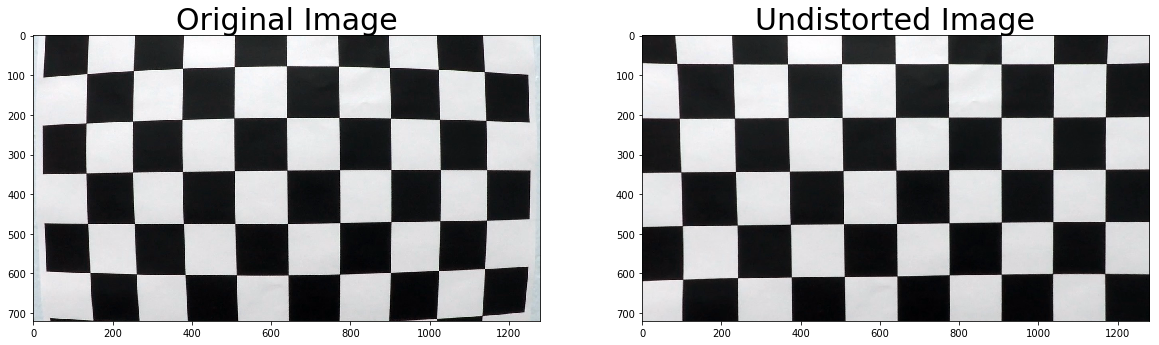

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
import numpy as np
import cv2

def abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=0, thresh_max=255):
    """Absolute Sobel Gradient Thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        thresh_min (int)
        thresh_max (int)
    """
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        
    # 3) Take the absolute value of the gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """Magnitude of Sobel in x and y directions and thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        mag_thresh (tuple) : (min, max) 2 element tuple 
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt( sobel_x**2 + sobel_y**2 )
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Direction of Sobel gradient in x and y combined then thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        thresh (tuple) : (min, max) 2 element tuple, default 0 to 90 degrees
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like( gradient )
    
    # 6) Return this mask as your binary_output image
    binary_output[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1

    return binary_output


In [5]:
def colorAndGradientThresholdBinary(img, color_thresh=(170, 255), sobel_thresh=(20, 100), ksize=3):
    """Use Sobel gradient and Color transforms to create a thresholded binary image

    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        color_thresh (tuple): Color channel threshold. Two element tuple.
        sobel_thresh (tuple): Sobel operator threshold. Two element tuple.
        ksize (int): Sobel operator kernel size.

    Returns:
        (color_binary, sx_binary, s_binary): color_binary, sx_binary, s_binary
    """
    img = np.copy(img)
    
    ### Sobel Gradient in x direction ( x direction accentuates vertical lines )
    #sx_binary = abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=sobel_thresh[0], thresh_max=sobel_thresh[1])
    
    ### Sobel magnitude
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=sobel_thresh) # (30,100) seems to work well
    
    ### Sobel direction (0.5 to 1.4) is about (30 to 80 degrees)
    dir_binary = dir_threshold(img, sobel_kernel=13, thresh=(0.5, 1.5))
    
    ### Combine magnitude and direction where both thresholds are satisfied
    # (note that magnitude and direction takes both individual Sobel x and y into account)
    sobel_combined_binary = np.zeros_like(dir_binary)
    sobel_combined_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

    ### Color Channel
    # Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    s_gradiented_binary = ((s_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 15) & (h_channel <= 30)] = 1
    
    color_combined_binary = np.zeros_like(s_binary)
    color_combined_binary[ (s_binary == 1) & ( h_binary == 1)] =1

    color_gradiented_binary = ((color_combined_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
        
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sobel_combined_binary), sobel_combined_binary, color_gradiented_binary))
    
    # Combine sobel and color results
    combined_binary = np.zeros_like(sobel_combined_binary)
    combined_binary[ (sobel_combined_binary == 1) | (color_gradiented_binary == 1) ] = 1
    
    return combined_binary, color_binary, \
        sobel_combined_binary, mag_binary, dir_binary, \
        s_gradiented_binary, s_binary, h_binary, color_gradiented_binary
    

type(image)=<class 'numpy.ndarray'>, image.shape=(720, 1280, 3)
type(color_binary)=<class 'numpy.ndarray'>, color_binary.shape=(720, 1280, 3)
type(sobel_binary)=<class 'numpy.ndarray'>, sobel_binary.shape=(720, 1280)
color_binary[360][0:10]=[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


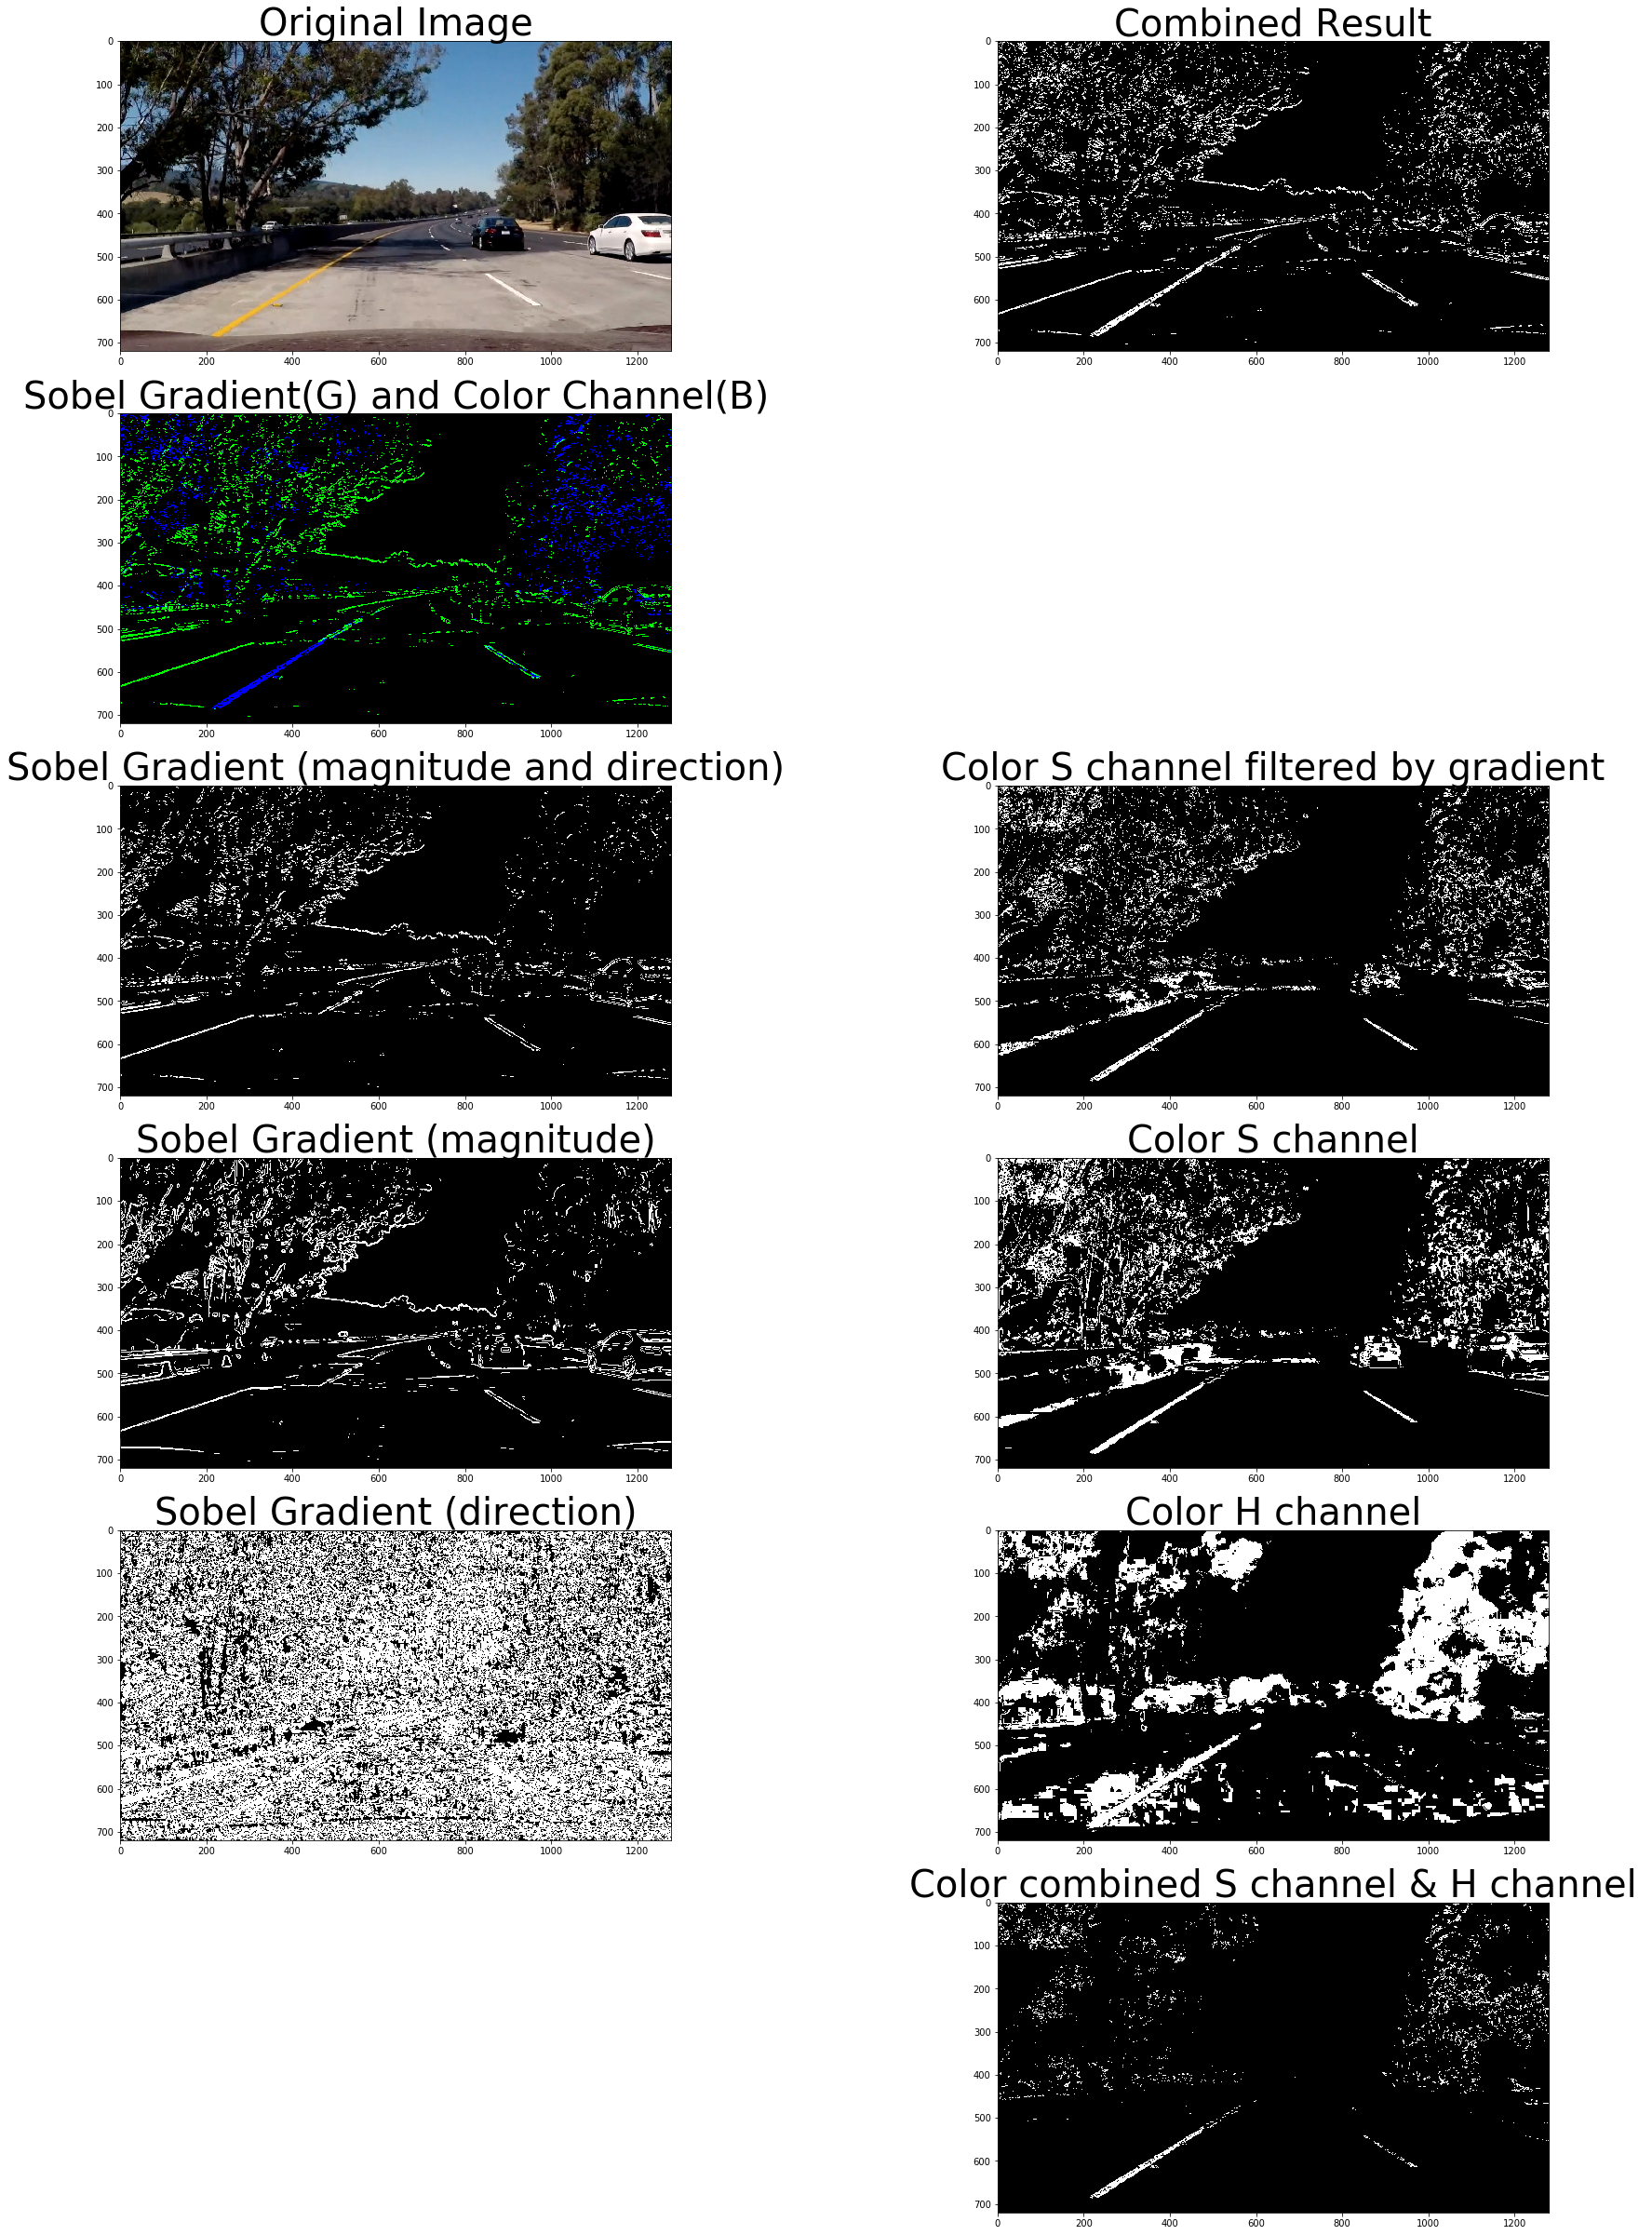

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
# image = mpimg.imread('./signs_vehicles_xygrad.png') 
image = mpimg.imread('./test_images/test5.jpg')

print("type(image)={}, image.shape={}".format( type(image), image.shape ))

combined_binary, color_binary, sobel_binary, mag_binary, dir_binary, s_gradiented_binary, s_binary, h_binary, color_combined_binary = \
    colorAndGradientThresholdBinary(image, color_thresh=(128, 255), sobel_thresh=(50, 135), ksize=5)

print("type(color_binary)={}, color_binary.shape={}".format( type(color_binary), color_binary.shape ))
print("type(sobel_binary)={}, sobel_binary.shape={}".format( type(sobel_binary), sobel_binary.shape ))
print("color_binary[360][0:10]={}".format( color_binary[360][0:10] ))
# Plot the result
f, axes = plt.subplots(6, 2, squeeze=False, figsize=(24, 36))
# f.tight_layout()

axes[0][0].imshow(image)
axes[0][0].set_title('Original Image', fontsize=40)

axes[0][1].imshow(combined_binary, cmap='gray')
axes[0][1].set_title('Combined Result', fontsize=40)

axes[1][0].imshow(color_binary)
axes[1][0].set_title('Sobel Gradient(G) and Color Channel(B)', fontsize=40)

axes[1][1].axis('off')

axes[2][0].imshow(sobel_binary, cmap='gray')
axes[2][0].set_title('Sobel Gradient (magnitude and direction)', fontsize=40)

axes[3][0].imshow(mag_binary, cmap='gray')
axes[3][0].set_title('Sobel Gradient (magnitude)', fontsize=40)

axes[4][0].imshow(dir_binary, cmap='gray')
axes[4][0].set_title('Sobel Gradient (direction)', fontsize=40)

axes[2][1].imshow(s_gradiented_binary, cmap='gray')
axes[2][1].set_title('Color S channel filtered by gradient', fontsize=40)

axes[3][1].imshow(s_binary, cmap='gray')
axes[3][1].set_title('Color S channel', fontsize=40)

axes[4][1].imshow(h_binary, cmap='gray')
axes[4][1].set_title('Color H channel', fontsize=40)

axes[5][0].axis('off')

axes[5][1].imshow(color_combined_binary, cmap='gray')
axes[5][1].set_title('Color combined S channel & H channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradient Usage
'And'ing gradient direction to magnitude helps to filter out horizontal lines (like the hood).

### Color Channel Usage
The H channel results in a noisy binary.  
S channel picks up lane lines well but also other features as well,
for example, it picks up the concrete barrier under the tree in image "test_images/test5.jpg".  

The S channel binary can be cleaned up by filtering ('and'ing) with the sobel gradient direction.

Combining S and H channel binaries by 'AND'ing removes noise such as the cars in image "test_images/test5.jpg".
Combining the combine S and H channel result by 'AND'ing with the Sobel gradient direciton further reduces noise.


## Image UnDistort

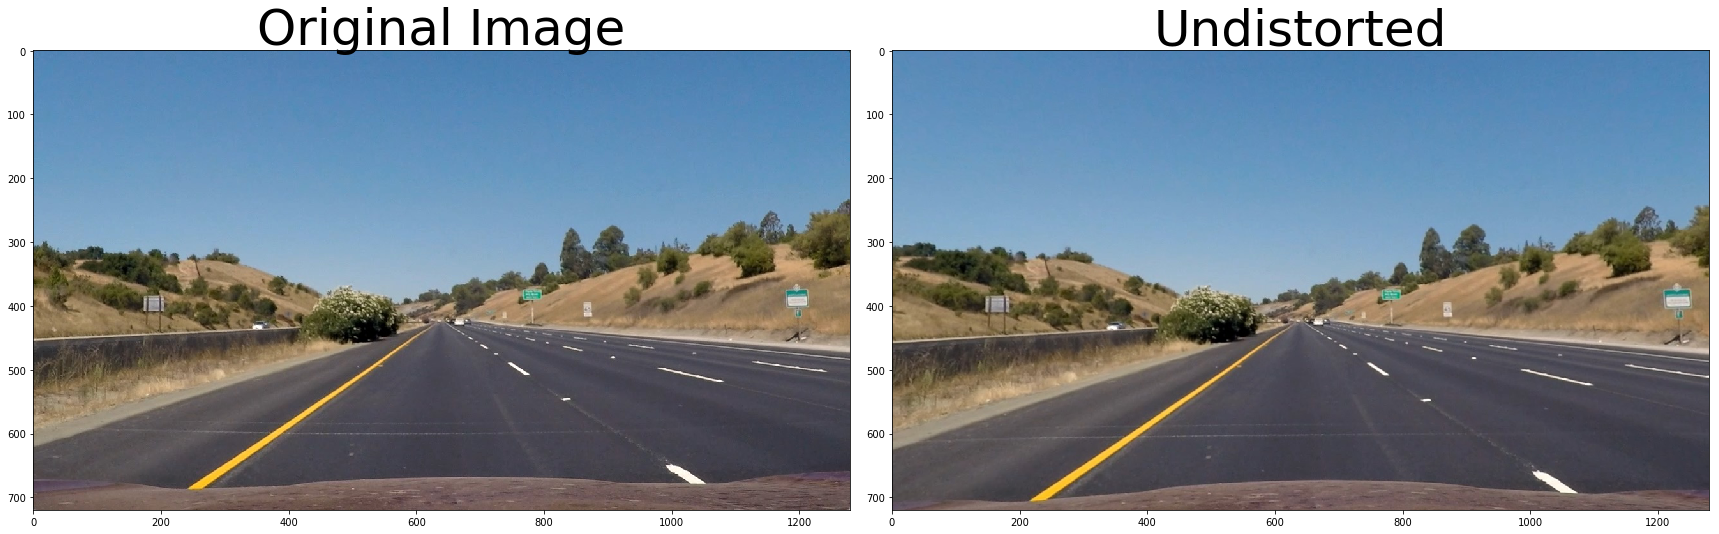

In [7]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
CALIBRATION = {'mtx': mtx, 'dist': dist}

# Read in an image
img_orig = mpimg.imread('test_images/straight_lines1.jpg')

# 1) Undistort using mtx and dist
img = cv2.undistort(img_orig, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orig)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [8]:
import cv2
import numpy as np

def image_warp(img, mtx, dist, M):
    """Warp image using perspective transform
    
    First, undistort image using camera calibration
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        mtx: camera matrix, 
        dist: distortion coefficients
        M: the transform matrix
        
    Returns:
        (warped): warped image
    """
        
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)

    img_size = (img.shape[1], img.shape[0]) # note switch of x,y order

    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

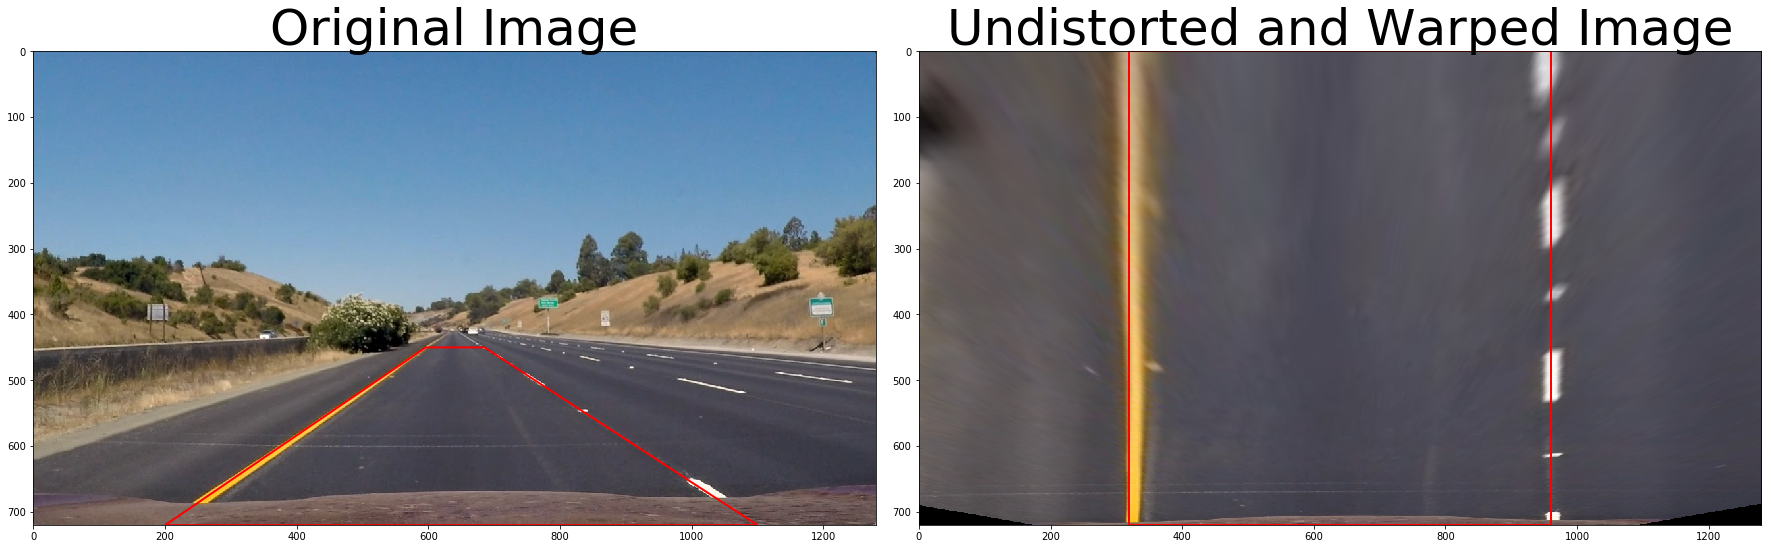

In [9]:
# Calculate the perspective transform matrix M and inverse Minv
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.path import Path
import matplotlib.patches as patches

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Define 4 source points 
# top left [622,435]
# top right [662,435]
# bottom right [1040,675]
# bottom left [272,675]
src_points = [[596,450],[685,450],[1100,720],[200,720]]
src = np.float32(src_points)

# Define 4 destination points
dst_points = [
    [320, 0], 
    [960, 0], 
    [960, 720], 
    [320, 720]]
dst = np.float32(dst_points)

# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Inverse transform matrix for transforming warped back to perspective view
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the perspective transform result for later use 
pXform_pickle = {}
pXform_pickle["M"] = M
pXform_pickle["Minv"] = Minv
pickle.dump( pXform_pickle, open( "./camera_cal/perspective_transform_pickle.p", "wb" ) )


# warp image
img_warped = image_warp(img, mtx, dist, M)

# display result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)

# draw the src points boundary
verts = np.float32( src_points + [src_points[0]] )
codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax1.add_patch(patch)

ax1.set_title('Original Image', fontsize=50)

ax2.imshow( img_warped )

# draw the dst points boundary
verts = np.float32( dst_points + [dst_points[0]] )

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax2.add_patch(patch)

ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


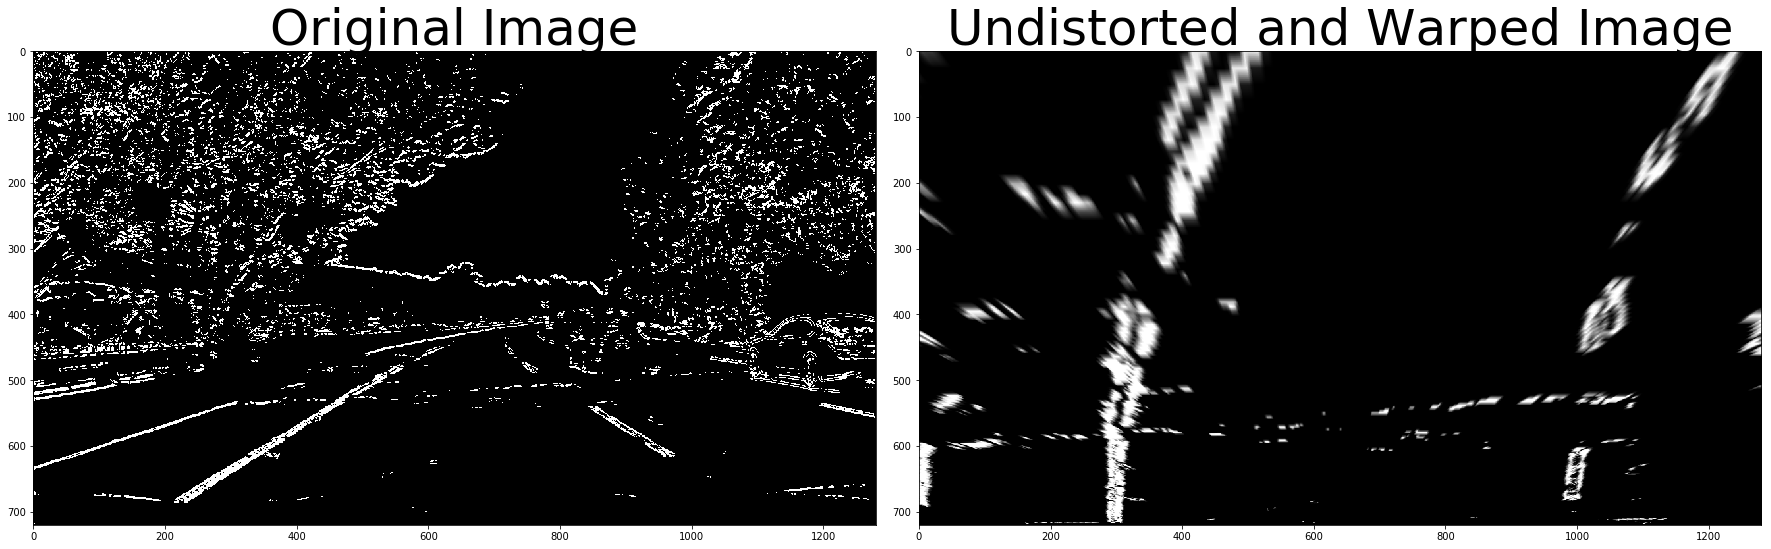

In [10]:
# Check curved lines from Gradient and Color threshold binary

# warp image
combined_binary_warped = image_warp(combined_binary, mtx, dist, M)

# display result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow( combined_binary, cmap='gray' )
ax1.set_title('Original Image', fontsize=50)

ax2.imshow( combined_binary_warped, cmap='gray' )
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

histogram.shape=(1280,)
midpoint=640, leftx_base=305, rightx_base=1007


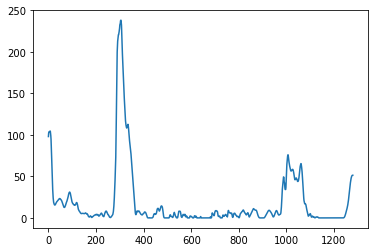

In [11]:
# histogram along all the columns in the lower half of the image
import numpy as np
img = combined_binary_warped
histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
print("histogram.shape={}".format(histogram.shape))
plt.plot(histogram)

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("midpoint={}, leftx_base={}, rightx_base={}".format(midpoint, leftx_base, rightx_base))

combined_binary_warped.shape=(720, 1280), out_img.shape=(720, 1280, 3)
combined_binary_warped[0][400:500]=[ 0.01062012  0.02124023  0.03451538  0.0451355   0.05841064  0.06903076
  0.08230591  0.16195679  0.2902832   0.39294434  0.52127075  0.62393188
  0.72659302  0.85491943  0.90625     0.90625     0.90625     0.90625
  0.90625     0.90625     0.90625     0.90652466  0.90789795  0.90899658
  0.91036987]
out_img[0][400:500]=[[ 2  2  0]
 [ 5  5  0]
 [ 8  8  0]
 [11 11  0]
 [14 14  0]]


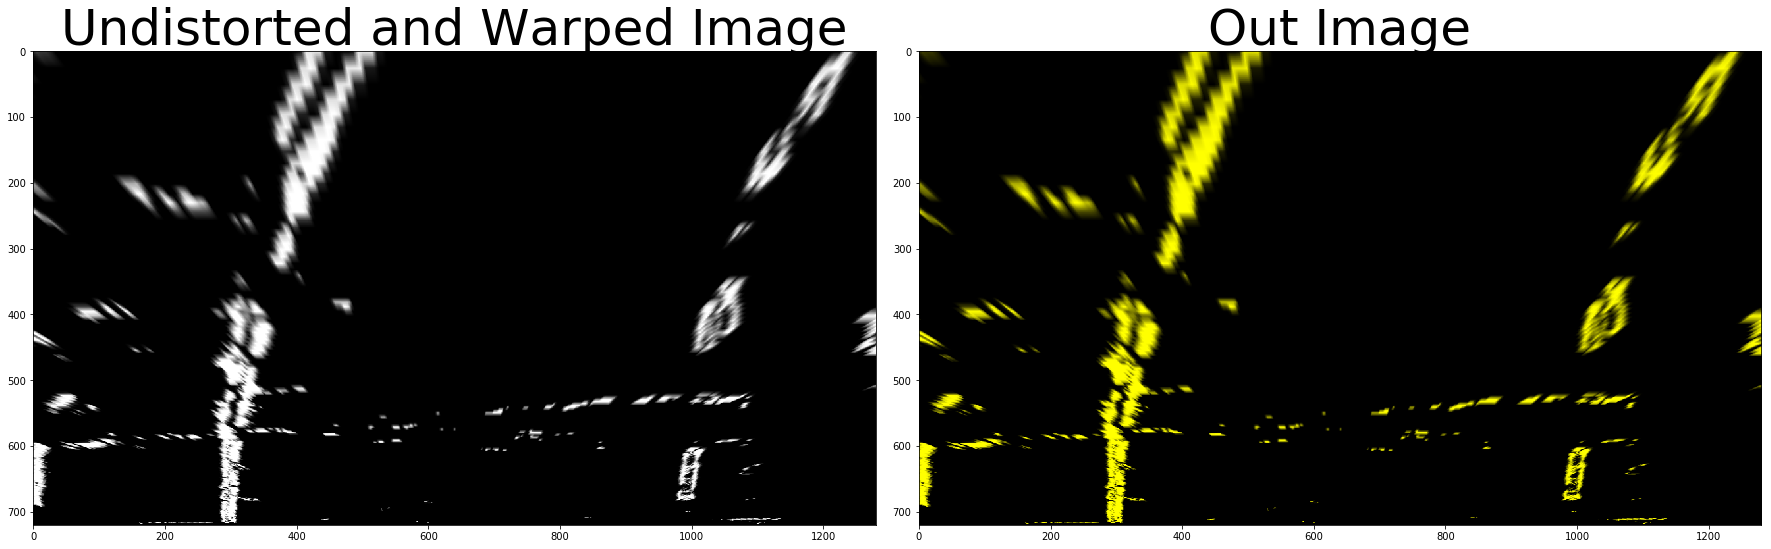

In [12]:
# Trying out how numpy dstack is used to create color images from binary image
binary_warped = combined_binary_warped
zeros = np.zeros_like(binary_warped)
out_img = np.dstack((binary_warped, binary_warped, np.zeros_like(binary_warped)))*255
out_img = out_img.astype(np.uint8) # convert to 8 bit binary for pyplot to interpret color correctly as 0-255

print("combined_binary_warped.shape={}, out_img.shape={}".format(combined_binary_warped.shape, out_img.shape))
print("combined_binary_warped[0][400:500]={}".format(combined_binary_warped[0][400:425]))
print("out_img[0][400:500]={}".format(out_img[0][400:405]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow( combined_binary_warped, cmap='gray' )
ax1.set_title('Undistorted and Warped Image', fontsize=50)

ax2.imshow( out_img )
ax2.set_title('Out Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [13]:
# nonzeros study
a = np.array([[1,0,0,0],[1,1,0,0],[1,1,1,0],[1,1,1,1]])
print("a=\n {}".format(a))
nz = np.nonzero(a)
print ("nz={}".format( nz ))
print ("nz[0]={}".format(nz[0]))

nzy = np.array(nz[0])
nzx = np.array(nz[1])
print("nzy={}, nzx={}".format(nzy, nzx))
print ( ((nzy >1) & (nzy <=2)).nonzero()[0] )


win_y_low = 2
win_y_high = 4

win_xleft_low = 0
win_xleft_high = 2

win_xright_low = 2
win_xright_high = 4
good_left_inds = ((nzy >= win_y_low) & (nzy < win_y_high) & (nzx >= win_xleft_low) & (nzx < win_xleft_high)).nonzero()[0]
good_right_inds = ((nzy >= win_y_low) & (nzy < win_y_high) & (nzx >= win_xright_low) & (nzx < win_xright_high)).nonzero()[0]
    
print("good_left_inds={}, good_right_inds{}".format(good_left_inds,good_right_inds))
print( ((nzy >= win_y_low) & (nzy < win_y_high) ).nonzero()[0] )
print( ((nzx >= win_xleft_low) & (nzx < win_xleft_high)).nonzero()[0] )
print( ((nzx >= win_xright_low) & (nzx < win_xright_high)).nonzero()[0] )

print ( nzx[good_right_inds] )
np.int(np.mean(nzx[good_right_inds]))

a=
 [[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]
nz=(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3]), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3]))
nz[0]=[0 1 1 2 2 2 3 3 3 3]
nzy=[0 1 1 2 2 2 3 3 3 3], nzx=[0 0 1 0 1 2 0 1 2 3]
[3 4 5]
good_left_inds=[3 4 6 7], good_right_inds[5 8 9]
[3 4 5 6 7 8 9]
[0 1 2 3 4 6 7]
[5 8 9]
[2 2 3]


2

In [14]:
# Curvature of lane lines
import numpy as np
def lane_curvature( leftx, lefty, rightx, righty, y_eval ):
    """
    Find Lane Curvature
    
    Args:
        leftx (ndarray): left line x pixel positions
        lefty (ndarray): left line y pixel positions
        rightx
        righty
        y_eval (int): y pixel position to evaluate curvature (usually at bottom of image (binary_warped.shape[0] - 1), closest to vehicle)
        
    Returns:
        (left_radius, right_radius)
    """

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in real world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate radius weighted by number of non-zero points on left and right lanes
    left_nonzeros = leftx.shape[0]
    right_nonzeros = rightx.shape[0]
    print("leftx.shape[0]={}, rightx.shape[0]={}".format(left_nonzeros, right_nonzeros))
    weighted_curverad = ((left_curverad * left_nonzeros) + (right_curverad * right_nonzeros))/(left_nonzeros + right_nonzeros)
    
    # # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', weighted_curverad, 'm')
    # # Example values: 632.1 m    626.2 m
    
    return (left_curverad, right_curverad, weighted_curverad)

## Implement Sliding Windows and Fit a Polynomial

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def slidingWindowsPolyFit( binary_warped ):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    # http://stackoverflow.com/questions/24739769/matplotlib-imshow-plots-different-if-using-colormap-or-rgb-array
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            #print("window={}, leftx_current={}".format(window, leftx_current))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            #print("window={}, rightx_current={}".format(window, rightx_current))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # for output image, color left lane points as red, right lane points as blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # note that the y,x params ordering int numpy.polyfit
    # "fitting for f(y), rather than f(x), 
    # because the lane lines in the warped image are near vertical and 
    # may have the same x value for more than one y value
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ###print("lefty.shape={}, left_fit={}".format(lefty.shape, left_fit))
    ###print("righty.shape={}, right_fit={}".format(righty.shape, right_fit))
    
    left_radius, right_radius, weighted_radius = lane_curvature( leftx, lefty, rightx, righty, binary_warped.shape[0] - 1 )
    
    return left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius


leftx.shape[0]=55090, rightx.shape[0]=26034
584.613578774 m 259.94849255 m 480.423316277 m
left_fit=[  2.80924574e-04  -4.41533348e-01   4.65168187e+02]
right_fit=[  6.32154684e-04  -7.49484878e-01   1.23557287e+03]
lane radius=480.4233162772573
out_img.shape=(720, 1280, 3)


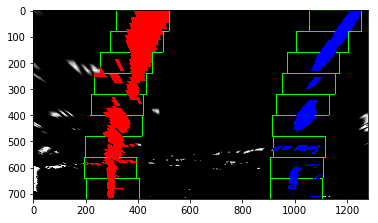

In [16]:
# test slidingWindowsPolyFit
left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = slidingWindowsPolyFit( combined_binary_warped )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))
print("lane radius={}".format(weighted_radius))
print("out_img.shape={}".format(out_img.shape))
plt.imshow(out_img)

### Visualization

binary_warped.shape=(720, 1280)


(720, 0)

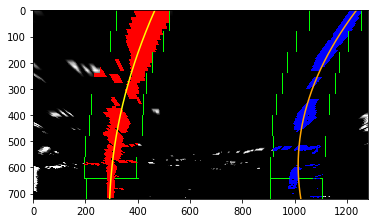

In [17]:
# Generate x and y values for plotting
print("binary_warped.shape={}".format(binary_warped.shape))
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# left and right lines from polyfit over y range
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='orange')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Look-Ahead Filter
Skip the sliding windows step once you know where the lines are

In [18]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
# (use the same image just to try out)

def lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=False ):
    """Look Ahead Filter
    
    Args:
        left_fit (array): 2nd order polynomial fit of left lane line from previous frame
        right_fit (array): 
        binary_warped (numpy.ndarray): thresholded binary
        lane_image (boolean): create lane image
        
    Return:
        left_fit: 2nd order polynomial fit of left lane line for current frame
        right_fit: 
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    # Get non-zeros within margin to either side of previous frame left, right lines
    left_line = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] 
    left_lane_inds = ((nonzerox > (left_line - margin)) & (nonzerox < (left_line + margin))) 

    right_line = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_line - margin)) & (nonzerox < (right_line + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if lane_image:
        # Create an image to draw on and an image to show the selection window
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[ ploty.astype(np.uint16), left_fitx.astype(np.uint16) ] = [255,255,0]
        out_img[ ploty.astype(np.uint16), right_fitx.astype(np.uint16) ] = [255,255,0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        out_img = None
    
    left_radius, right_radius, weighted_radius = lane_curvature( leftx, lefty, rightx, righty, binary_warped.shape[0] - 1 )
    
    return left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius


leftx.shape[0]=55234, rightx.shape[0]=26242
671.433508339 m 254.630570464 m 537.188544231 m
left_fit=[  2.44621546e-04  -4.23458303e-01   4.67905806e+02]
right_fit=[  6.45409006e-04  -7.58428234e-01   1.23674458e+03]
lane radius=537.1885442305925
out_img.shape=(720, 1280, 3)


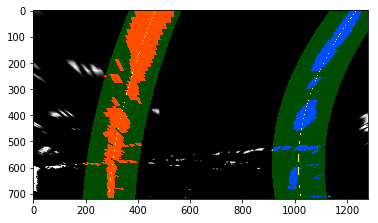

In [19]:
left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=True )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))
print("lane radius={}".format(weighted_radius))
print("out_img.shape={}".format(out_img.shape))
plt.imshow(out_img)

### Visualize

ploty.shape=(720,), ploty[0:8]=[0 1 2 3 4 5 6 7]
left_fitx.shape=(720,), left_fitx[0:8]=[467 467 467 466 466 465 465 464]


(720, 0)

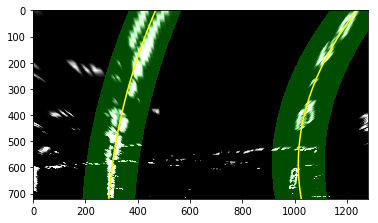

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print("ploty.shape={}, ploty[0:8]={}".format(ploty.shape, ploty.astype(np.uint16)[0:8]))
print("left_fitx.shape={}, left_fitx[0:8]={}".format(left_fitx.shape, left_fitx.astype(np.uint16)[0:8]))

# Create an image to draw on and an image to show the selection window
out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Project lines on original image

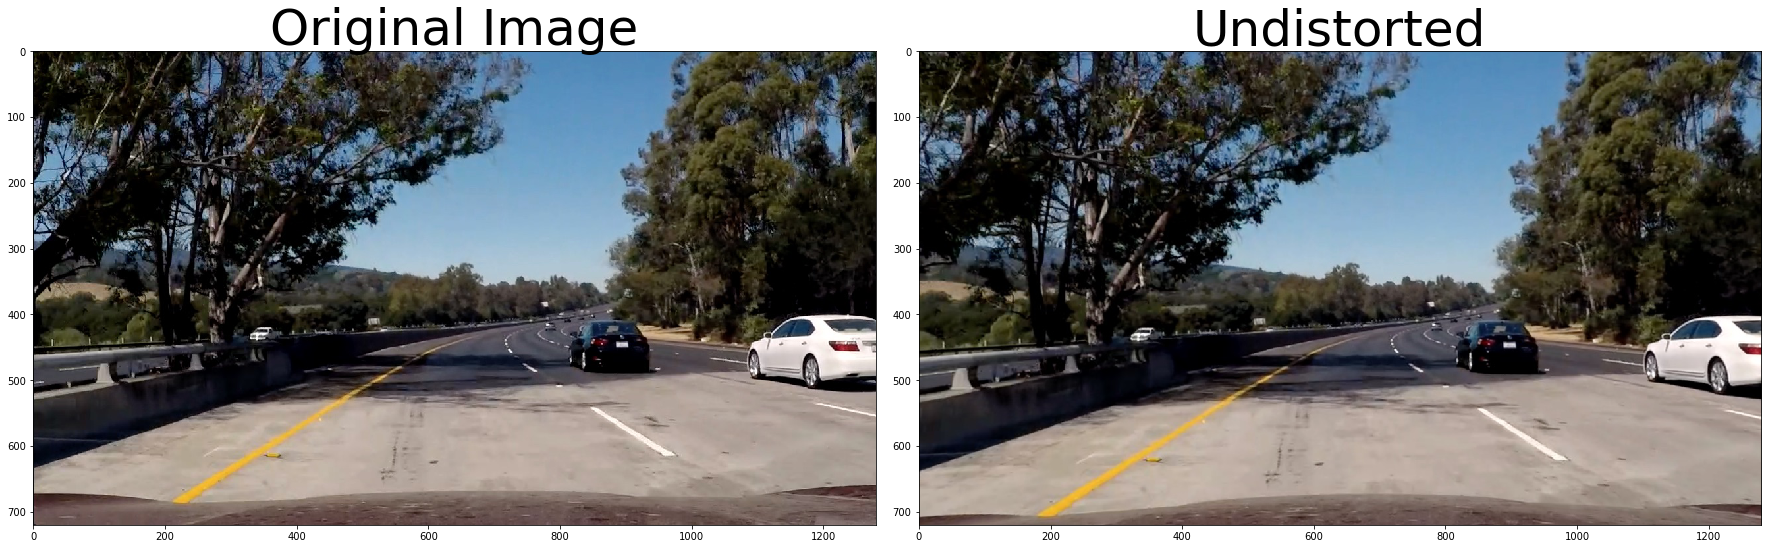

In [21]:
# see what cv2.undistort image looks like (this was done previously with straight lane lines)
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


color_warp.shape=(720, 1280, 3)


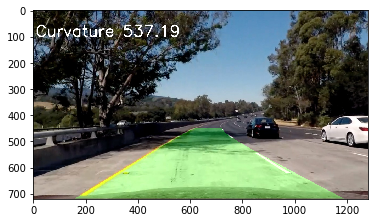

In [22]:
warped = binary_warped

# Project lines on original image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
print("color_warp.shape={}".format(color_warp.shape))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
lane_image = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)

font = cv2.FONT_HERSHEY_SIMPLEX
a_str = "Curvature {0:.2f}".format(weighted_radius)
cv2.putText(lane_image,a_str,(10,100), font, 2,(255,255,255),3,cv2.LINE_AA)
    
plt.imshow(lane_image)

In [23]:
#TODO: leftx,lefty,rightx, righty has to be exposed from lookAheadFilter
# # Curvature of lane lines

# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # evaluate curvature at bottom of image, closest to vehicle
# y_eval = binary_warped.shape[0] - 1 

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

In [24]:
# #TODO: need left_fit_cr, from previous block
# # left and right line separation (lane width)
# left_fit_cr.shape

# # Calculate left and right x at bottom of image
# # Approach 1. adjust pixel value result be xm_per_pix
# left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
# right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
# lane_width_1 = (right_x - left_x) * xm_per_pix

# print("left_fit={}".format(left_fit))
# print("right_fit={}".format(right_fit))
# print("y_eval={}".format(y_eval))
# print("left_x={}, right_x={}".format(left_x, right_x))
# print( lane_width_1 )

# assert 2 < lane_width_1 < 5.5, "lane width should be reasonable: %r" % lane_width_1

# # Approach 2. calculate from meters polyfit (both should have same result)
# y_eval_adj = y_eval * ym_per_pix
# left_x = left_fit_cr[0]*y_eval_adj**2 + left_fit_cr[1]*y_eval_adj + left_fit_cr[2]
# right_x = right_fit_cr[0]*y_eval_adj**2 + right_fit_cr[1]*y_eval_adj + right_fit_cr[2]
# lane_width_2 = (right_x - left_x)

# print("left_fit_cr={}".format(left_fit_cr))
# print("right_fit_cr={}".format(right_fit_cr))
# print("y_eval={}".format(y_eval))
# print("left_x={}, right_x={}".format(left_x, right_x))
# print( lane_width_2 )

# assert abs(lane_width_1 - lane_width_2) < 0.0001, "both values should be close: %r, %r" % (lane_width_1, lane_width_2)

## Measuring Curvature


In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
# # Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

In [26]:
# # Define y-value where we want radius of curvature
# # I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# # Example values: 1926.74 1908.48

### calculation of radius of curvature after correct for scale in x and y

In [27]:
# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

## Tracking

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel

## Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

## Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

In [29]:
## Collect transforms into pipeline function

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
def find_lane( image, mtx, dist, M, plot=False, left_fit=None, right_fit=None ):
    """
    Find Lane
    
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
    If lane line polynomial fit is available from previous frame, for current frame poly fit
      Use look ahead filter method
    else:
      Use sliding window method
    
    Args:
        image (numpy.ndarray): Source image. Color channels in RGB order.
        mtx: camera matrix, 
        dist: distortion coefficients
        M: the transform matrix
        left_fit: polyfit from previous frame
        right_fit:
        
    Returns:
        (left_fit, right_fit, warped): warped image
    """
        
    ###print("type(image)={}, image.shape={}".format( type(image), image.shape ))

    # 1. color and gradient binary
    threshold_binaries = \
        colorAndGradientThresholdBinary(image, color_thresh=(128, 255), sobel_thresh=(50, 135), ksize=5)
    combined_binary = threshold_binaries[0]
    
    if plot:
        # Plot the color and gradient result
        f, axes = plt.subplots(1, 2, squeeze=False, figsize=(24, 9))
        f.suptitle('Gradient and Color Threshold', fontsize=32)
        f.tight_layout()
        axes[0][0].imshow(image)
        axes[0][0].set_title('Original Image - undistorted', fontsize=40)
        axes[0][1].imshow(combined_binary, cmap='gray')
        axes[0][1].set_title('Combined Binary', fontsize=40)
    
    # 2. undistort and warp image
    binary_warped = image_warp(combined_binary, mtx, dist, M)

    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.suptitle('Undistort', fontsize=32)
        f.tight_layout()
        ax1.imshow(combined_binary, cmap='gray')
        ax1.set_title('Combined Binary', fontsize=40)
        ax2.imshow(binary_warped, cmap='gray')
        ax2.set_title('Undistorted and Warped', fontsize=40)
    
    # 3. Sliding windows fit on first image
    if left_fit is None:
        left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = slidingWindowsPolyFit( binary_warped )
        fit_title = 'Sliding window fit'
        ###print("Sliding window fit left_fit={}, right_fit={}".format(left_fit, right_fit))
    else:
        left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=plot )
        fit_title = 'Look ahead filter fit'
        ###print("Look ahead filter fit left_fit={}, right_fit={}".format(left_fit, right_fit))
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # left and right lines from polyfit over y range
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # color left lane points as red, right lane points as blue
        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        f, (ax1) = plt.subplots(1,1, figsize=(6,4))
        f.tight_layout()
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='orange')
        ax1.set_title(fit_title, fontsize=40)
        
    return left_fit, right_fit, binary_warped, weighted_radius
    

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
image = mpimg.imread('./test_images/straight_lines1.jpg')


leftx.shape[0]=55067, rightx.shape[0]=31907
10750.6712193 m 2775.20728353 m 7824.81834603 m
left_fit=[ -1.52759563e-05   1.81845517e-02   3.21583180e+02]
right_fit=[ -5.91777177e-05   5.45200092e-02   9.50597896e+02]


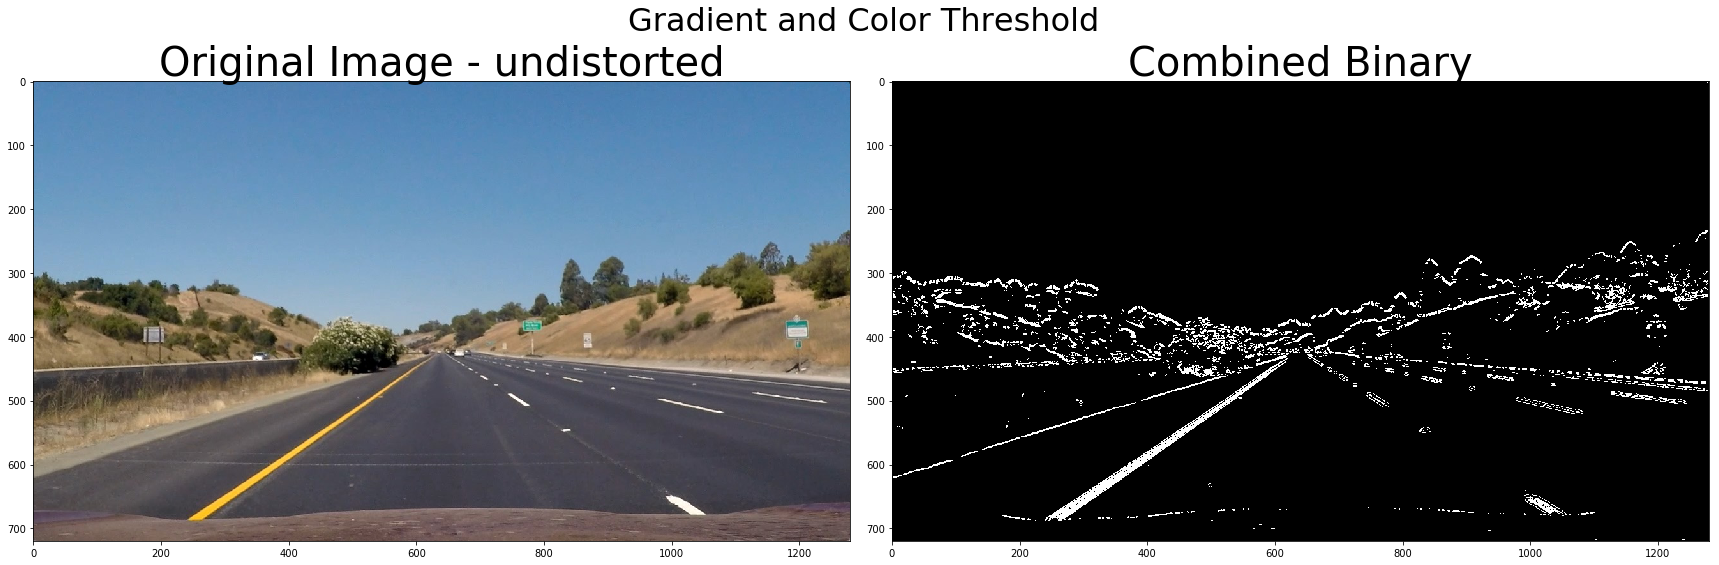

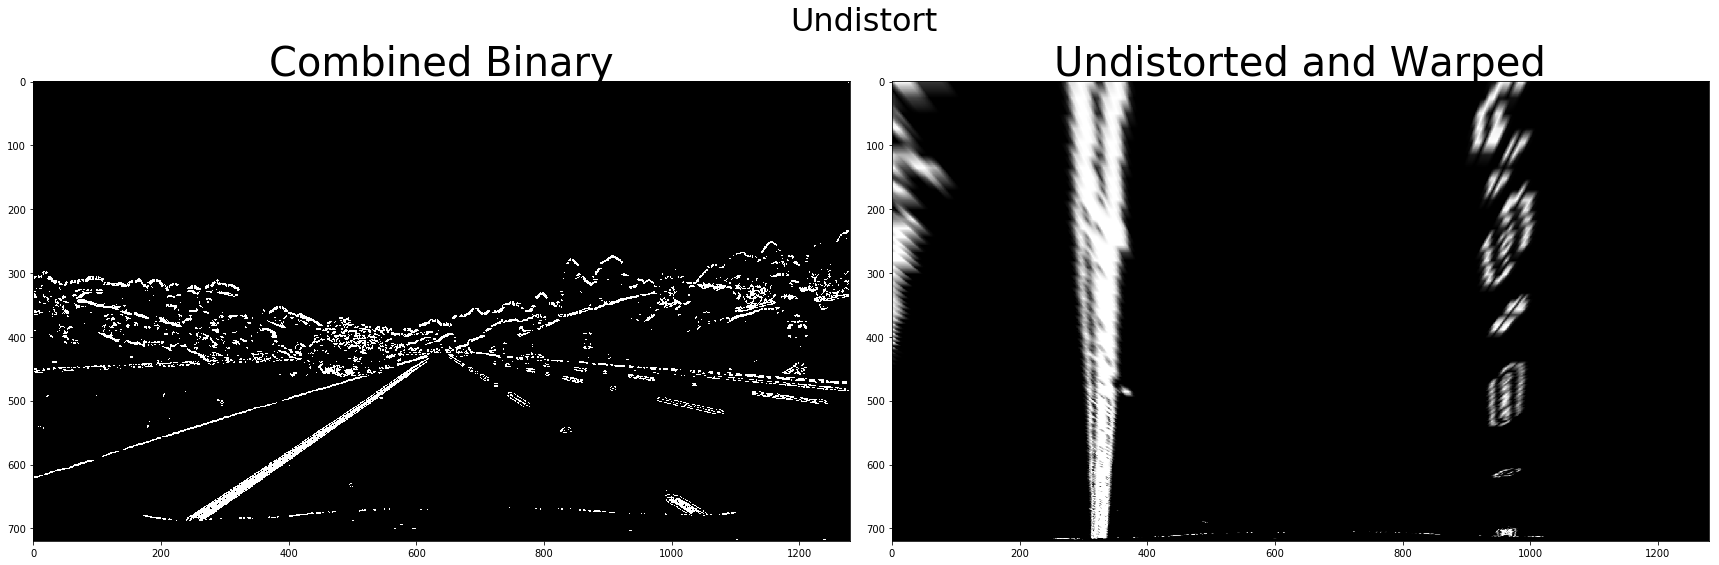

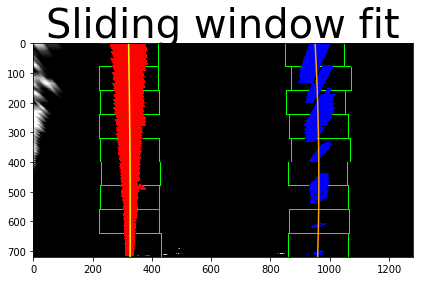

In [31]:
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, plot=True )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

leftx.shape[0]=55067, rightx.shape[0]=31907
10750.6712193 m 2775.20728354 m 7824.81834606 m
left_fit=[ -1.52759563e-05   1.81845517e-02   3.21583180e+02]
right_fit=[ -5.91777177e-05   5.45200092e-02   9.50597896e+02]


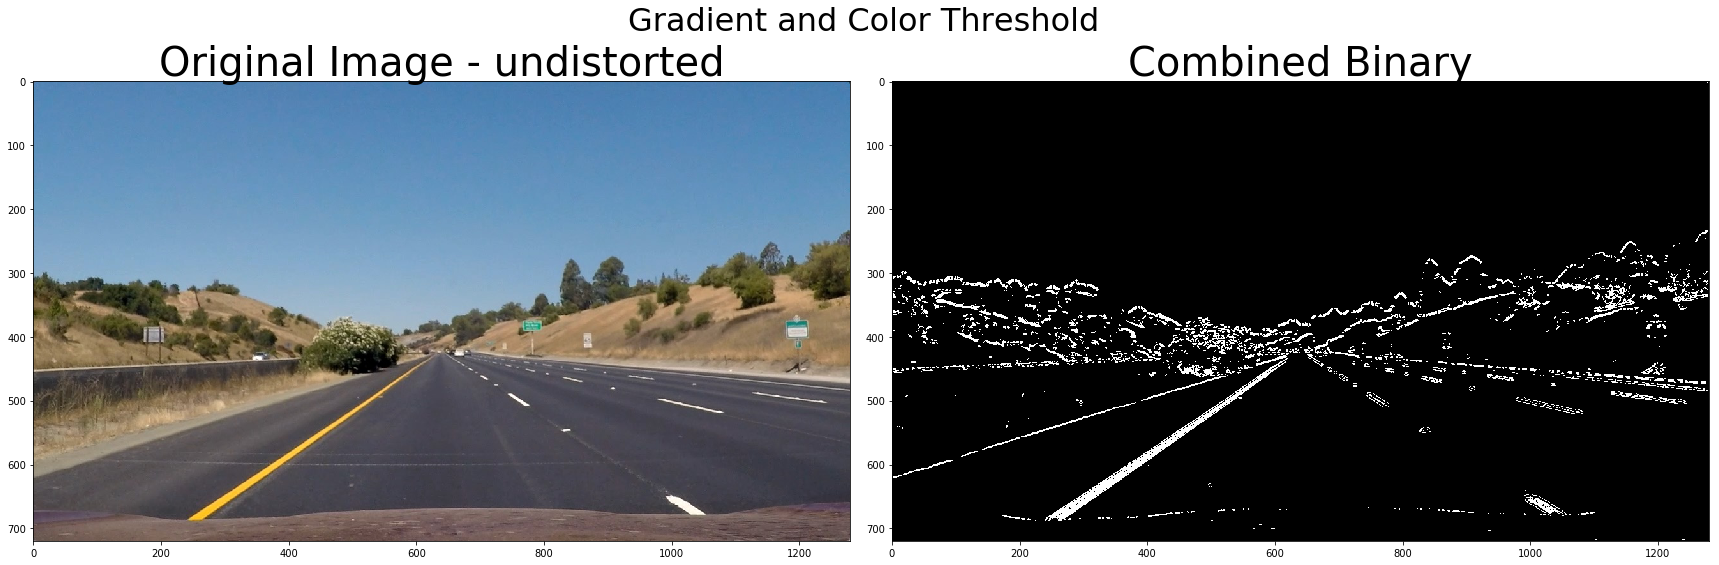

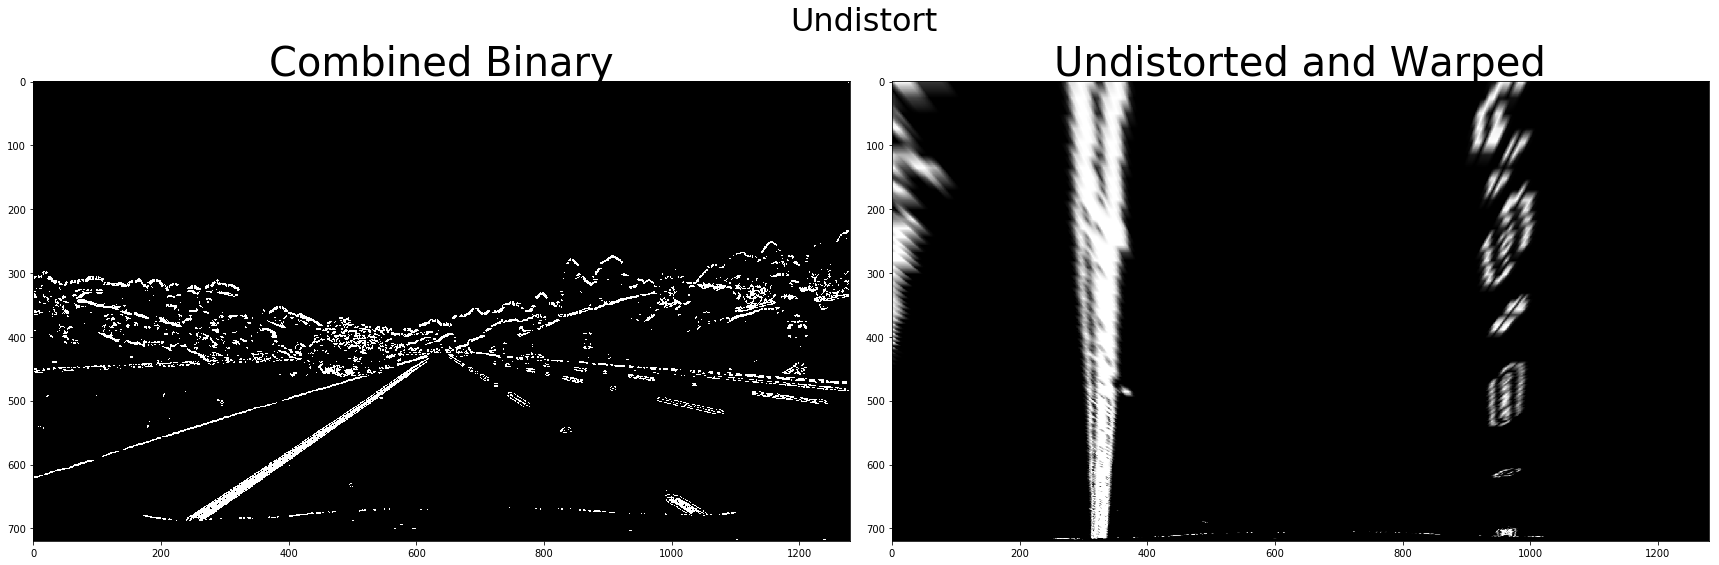

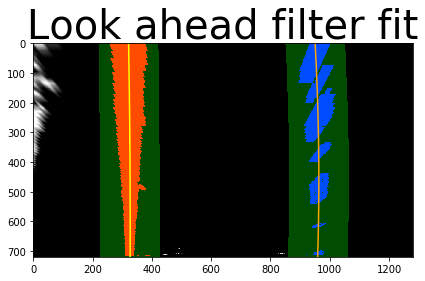

In [32]:
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, plot=True, left_fit=left_fit, right_fit=right_fit )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

In [33]:
# plot lane overlay on original image
def plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius ):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Project lines on original image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ###print("color_warp.shape={}".format(color_warp.shape))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    image_with_lane = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    annotate_str = "Radius {0:.2f}m".format(lane_radius)
    cv2.putText(image_with_lane,annotate_str,(10,100), font, 2,(255,255,255),3,cv2.LINE_AA)
    
    return image_with_lane



leftx.shape[0]=55067, rightx.shape[0]=31907
10750.6712193 m 2775.20728353 m 7824.81834603 m
left_fit=[ -1.52759563e-05   1.81845517e-02   3.21583180e+02]
right_fit=[ -5.91777177e-05   5.45200092e-02   9.50597896e+02]


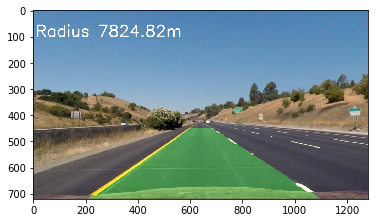

In [34]:
# test plot_lane with find_lane sliding windows
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius)

plt.imshow(image_with_lane)

In [35]:
# test plot_lane with find_lane look ahead filter
left_fit, right_fit, binary_warped = find_lane( image, mtx, dist, M, left_fit=left_fit, right_fit=right_fit )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist)

plt.imshow(image_with_lane)

leftx.shape[0]=55067, rightx.shape[0]=31907
10750.6712193 m 2775.20728354 m 7824.81834606 m


ValueError: too many values to unpack (expected 3)

In [ ]:
# run find_lane with test images
import os
img_dir = './test_images/'
count=1
for img_path in os.listdir( img_dir ):
    image = mpimg.imread( img_dir + img_path )
    
    left_fit, right_fit, binary_warped = find_lane( image, mtx, dist, M )
    print("image path={}".format(img_path))
    print("left_fit={}".format(left_fit))
    print("right_fit={}".format(right_fit))

    image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist)

    plt.figure(count)
    plt.imshow(image_with_lane)
    count += 1


In [ ]:
# find lane and plot lane on image
def process_image(image):
    
    left_fit, right_fit, binary_warped = find_lane( image, mtx, dist, M )
    image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist)
    return image_with_lane

In [ ]:
image = mpimg.imread('./debug_images/orig/frame330.jpg')
left_fit, right_fit, binary_warped = find_lane( image, mtx, dist, plot=True )
image_with_lane = process_image(image)
plt.imshow(image_with_lane)

In [ ]:
# try images from project video
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture('project_video.mp4')
ret, frame = cap.read()
print("frame.shape={}".format(frame.shape))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite('./debug_images/project_video_frame1.jpg', frame)
plt.figure(1)
plt.imshow(frame_rgb)

# # 1. color and gradient binary
# threshold_binaries = \
#     colorAndGradientThresholdBinary(frame_rgb, color_thresh=(128, 255), sobel_thresh=(50, 135), ksize=5)
# combined_binary = threshold_binaries[0]

# # Plot the color and gradient result
# f, axes = plt.subplots(1, 2, squeeze=False, figsize=(24, 9))
# f.suptitle('Gradient and Color Threshold', fontsize=32)
# f.tight_layout()
# axes[0][0].imshow(frame_rgb)
# axes[0][0].set_title('Original Image - undistorted', fontsize=40)
# axes[0][1].imshow(combined_binary, cmap='gray')
# axes[0][1].set_title('Combined Binary', fontsize=40)
        
# left_fit, right_fit, binary_warped = find_lane( frame_rgb, mtx, dist, plot=True )
# plt.figure(2)
# plt.imshow(binary_warped)

# image_with_lane = plot_lane( frame_rgb, binary_warped, left_fit, right_fit, Minv, mtx, dist)

image_with_lane = process_image(frame_rgb)
cv2.imwrite('./debug_images/project_video_frame1_lane.jpg', image_with_lane)
plt.figure(2)
plt.imshow(image_with_lane)
        
cap.release()
# cv2.destroyAllWindows()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

project_output = 'project_output_video.mp4'
clip = VideoFileClip("project_video.mp4").subclip(0,15)
project_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('project_video.mp4')
count = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    if count%100 == 0:
        print("count={}".format(count))
        
    if 250 <= count <= 378:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imwrite('./debug_images/orig/frame' + str(count) + '.jpg', cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR) )
        image_with_lane = process_image(frame_rgb)
        cv2.imwrite('./debug_images/lane/frame' + str(count) + '.jpg', cv2.cvtColor(image_with_lane, cv2.COLOR_RGB2BGR) )
        print("processing frame {}".format(count))

cap.release()
print("total count={}".format(count))